# Angle estimation

### 1. Import libs

In [189]:
import os
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt


### 2. Preprocess

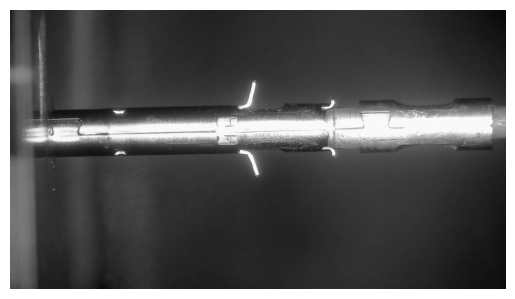

In [244]:
image_path = 'data\ok_26_20180623-10531529726031_3.jpg'
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.axis('off')
plt.imshow(gray_image, cmap='gray')
plt.show()


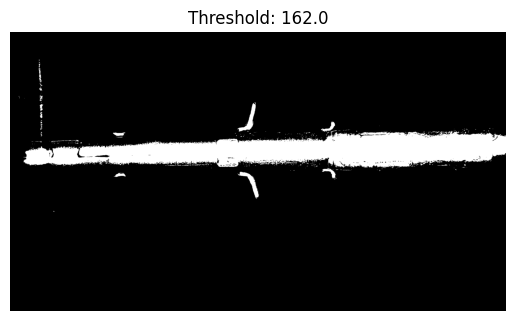

In [191]:
# Auto 
(thresh, binary_image) = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.axis('off')
plt.title('Threshold: {}'.format(thresh))
plt.imshow(binary_image, cmap='gray')
plt.show()

In [192]:
def to_binary(im_gray, threshold):
    im_bw = cv2.threshold(im_gray, threshold, 255, cv2.THRESH_BINARY)[1]
    return im_bw

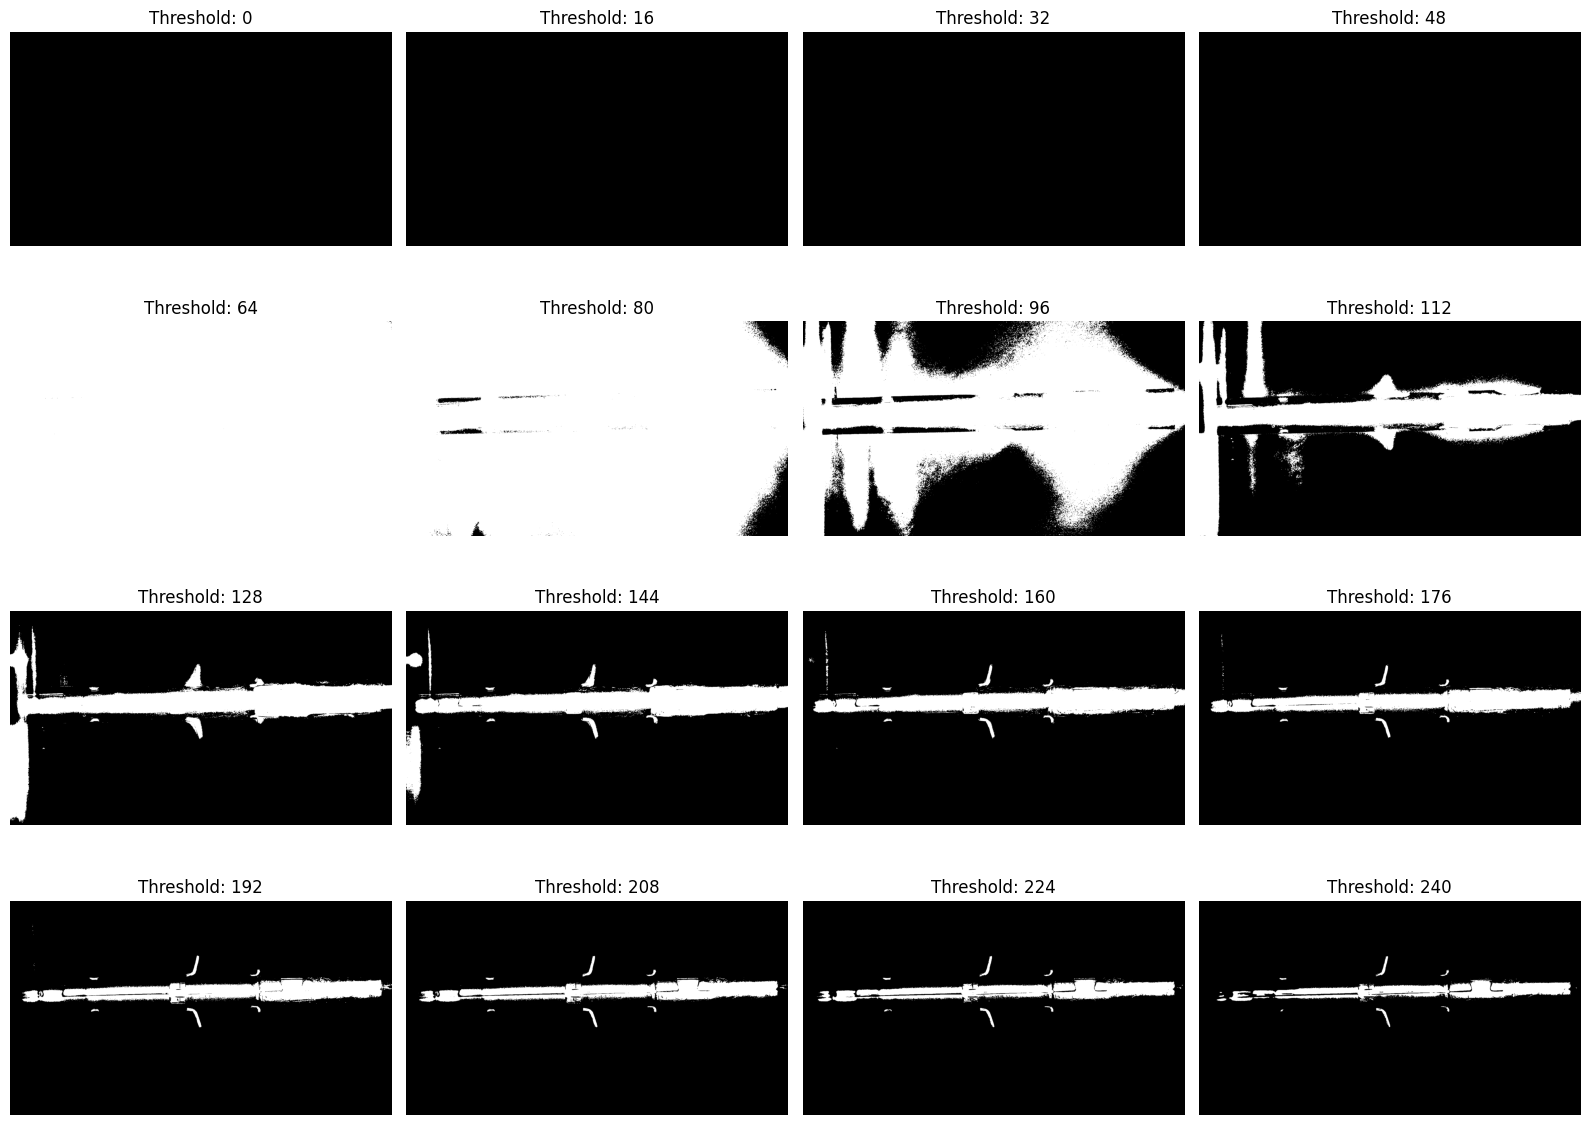

In [193]:
plt.figure(figsize=(16, 12))

for i, thresh in enumerate(range(0, 255, 16)):
    plt.subplot(4, 4, i + 1)
    im_bw = to_binary(gray_image, thresh)
    plt.axis('off')
    plt.title('Threshold: {}'.format(thresh))
    plt.imshow(im_bw, cmap='gray')

plt.tight_layout()
plt.savefig('save/binary_threshold.jpg')
plt.show()

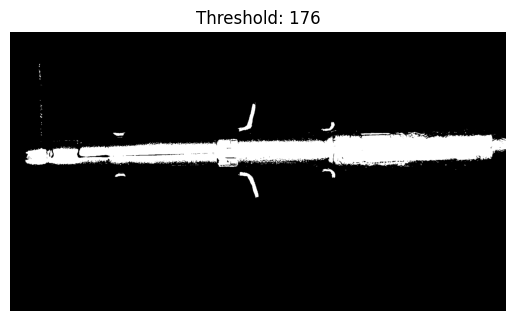

In [194]:
# Test with threshold 192
thresh = 176
binary_image = to_binary(gray_image, thresh)
noiseless_binary_image = cv2.fastNlMeansDenoising(binary_image, None, 20, 7, 21) 
plt.axis('off')
plt.title('Threshold: {}'.format(thresh))
plt.imshow(noiseless_binary_image, cmap='gray')
plt.show()

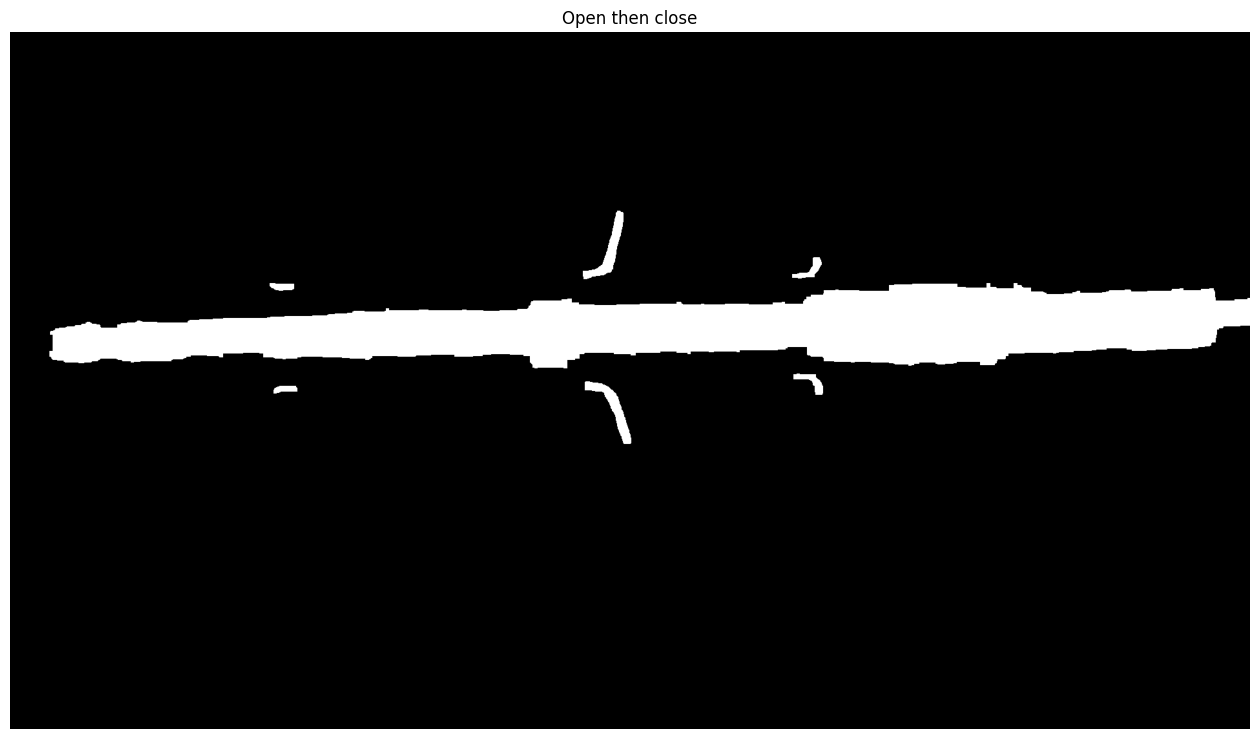

In [195]:
# Remove noise using open
kernel = np.ones((5, 5),np.uint8)
opening = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

# close
kernel = np.ones((25, 25), np.uint8)
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

plt.figure(figsize=(16, 12))
plt.axis('off')
plt.title('Open then close')
plt.imshow(closing, cmap='gray')
plt.show()

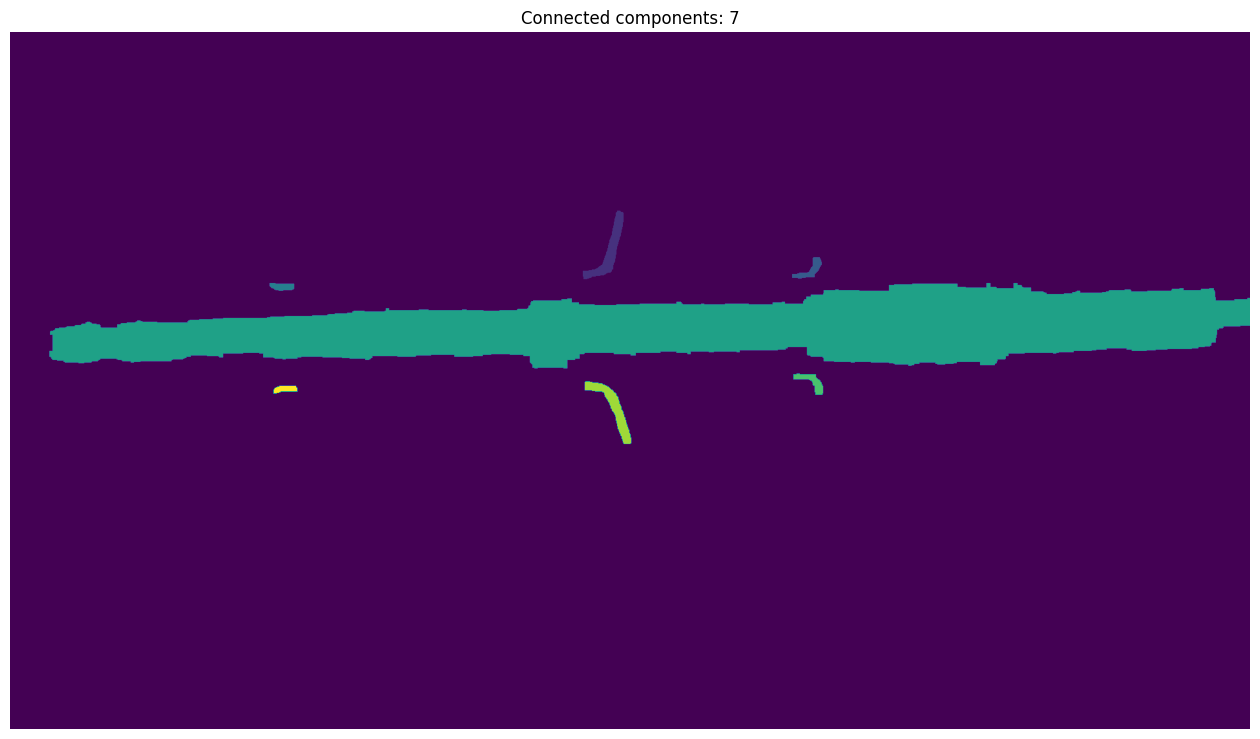

In [196]:
num_labels, labels_im = cv2.connectedComponents(closing)
plt.figure(figsize=(16, 12))
plt.axis('off')
plt.title('Connected components: {}'.format(num_labels - 1))
plt.imshow(labels_im)
plt.show()

In [205]:
def filter_label(labelled_img, label_list, threshold=1000):
    def area(label):
        return np.sum(labelled_img == label)
    
    result = []
    for label in label_list:
        if area(label) >= threshold:
            result.append(label)
            
    return result

filtered_labels = filter_label(labels_im, list(range(1, num_labels)))
print('Filered labels: ', filtered_labels)

Filered labels:  [1, 4, 6]


In [207]:
def area_sort(filtered_list, labelled_img):
    def area(label):
        return np.sum(labelled_img == label)
    
    return sorted(filtered_list, key=area, reverse=True)

sorted_labels = area_sort(filtered_labels, labels_im)
print("Sort by area: ", sorted_labels)

Sort by area:  [4, 1, 6]


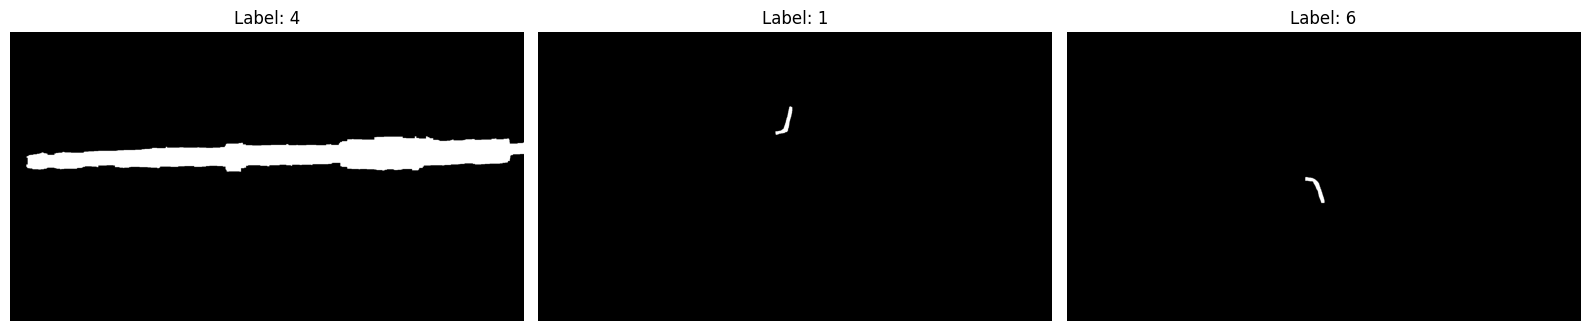

In [208]:
# Extract component from binary image
def extract_component(binary_im, label_im, label):
    return (label_im == label) * binary_im

# Example
plt.figure(figsize=(16, 14))
for i, label in enumerate(sorted_labels):
    comp = extract_component(closing, labels_im, label)
    plt.subplot(1, 3, i + 1)
    plt.axis('off')
    plt.title("Label: {}".format(label))
    plt.imshow(comp, cmap='gray')

plt.tight_layout()
plt.savefig('./save/extracted_comp.jpg')
plt.show()

### 3. Side axis

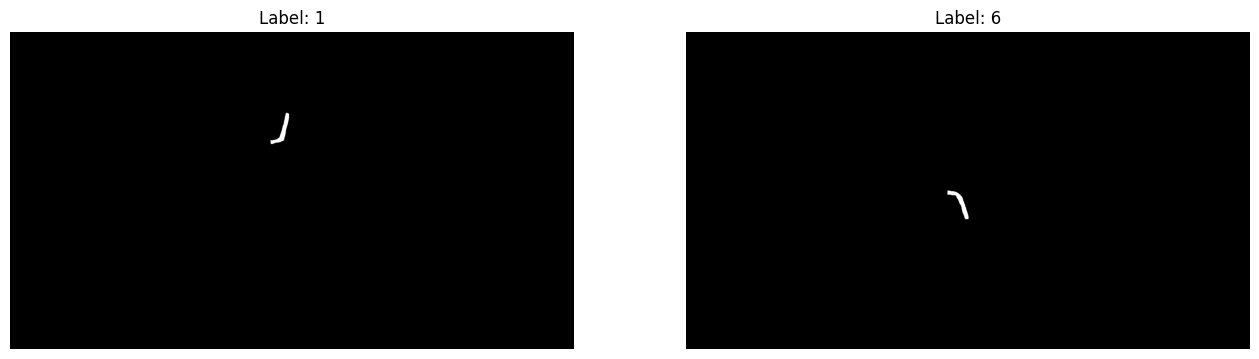

In [213]:
labels = sorted_labels[1:]
side_comp_1 = extract_component(closing, labels_im, labels[0])
side_comp_2 = extract_component(closing, labels_im, labels[1])

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.title("Label: {}".format(labels[0]))
plt.imshow(side_comp_1, cmap='gray')

plt.subplot(1, 2, 2)
plt.axis('off')
plt.title("Label: {}".format(labels[1]))
plt.imshow(side_comp_2, cmap='gray')

plt.show()

In [247]:
def edge_detector(image, thresh):
    canny_image = cv2.Canny(image, 70, 200)
    lines = cv2.HoughLines(canny_image, 1, np.pi/180, thresh)
    return lines

def draw_line(image, rho, theta, color=(255, 0, 0)):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 10000 * (-b))
    y1 = int(y0 + 10000 * (a))
    x2 = int(x0 - 10000 * (-b))
    y2 = int(y0 - 10000 * (a))
    cv2.line(image, (x1, y1), (x2, y2), color, 2)
    return image

def display_lines(image, thresh):
    image_copy = image.copy()
    lines = edge_detector(image_copy, thresh)
    if lines is not None: 
        
        # Longest line
        rho, theta = lines[0][0]
        draw_line(image_copy, rho, theta)
        return image_copy, rho, theta
    
    else:
        return image_copy, 0, 0

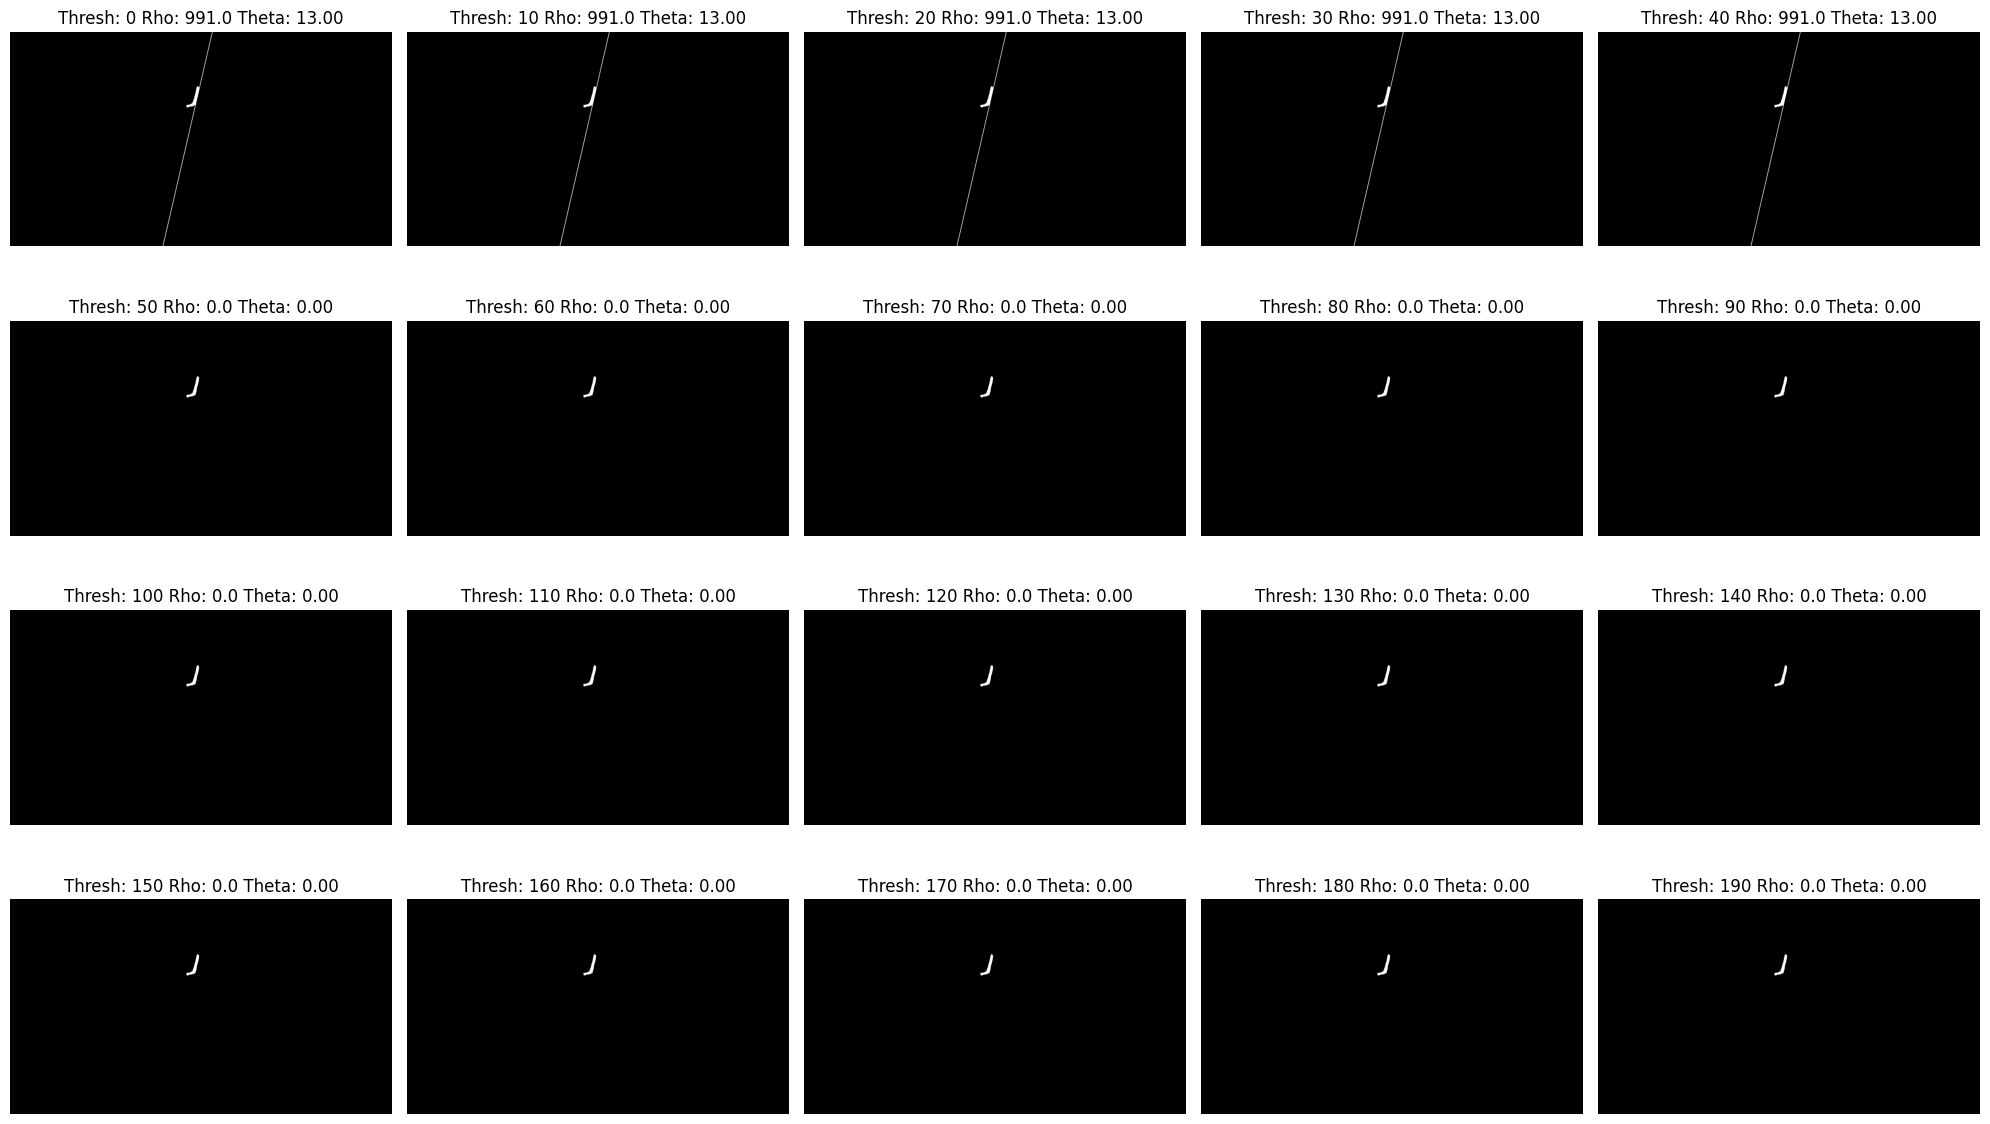

In [215]:
plt.figure(figsize=(20, 12))
for i, thresh in enumerate(range(0, 200, 10)):
    line_image, rho, theta = display_lines(side_comp_1, thresh)
    
    plt.subplot(4, 5, i + 1)
    plt.axis('off')
    plt.title('Thresh: {} Rho: {:.1f} Theta: {:.2f}'.format(thresh, rho, theta / np.pi * 180))
    plt.imshow(line_image, cmap='gray')

plt.tight_layout()
plt.savefig('./save/edge_detector_1.jpg')
plt.show()

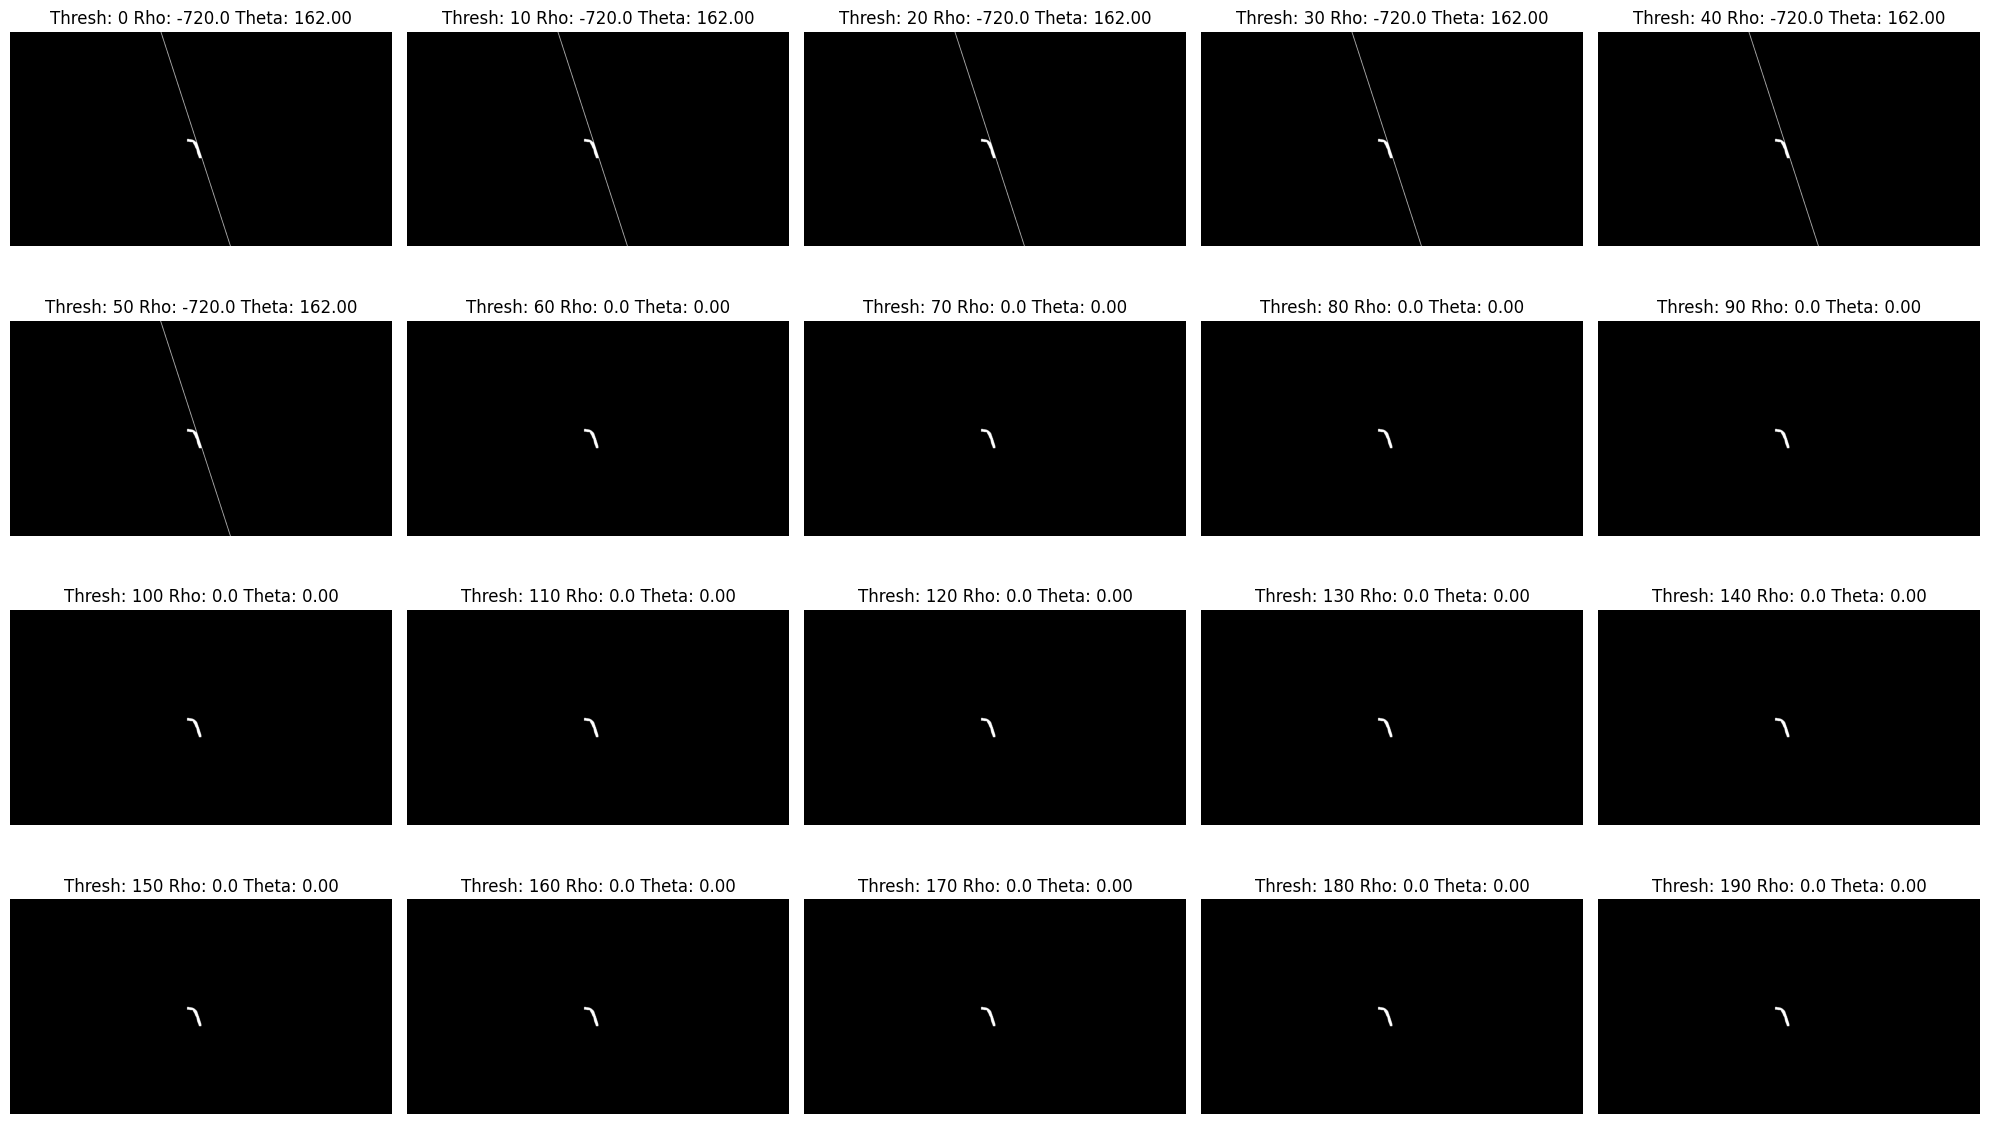

In [216]:
plt.figure(figsize=(20, 12))
for i, thresh in enumerate(range(0, 200, 10)):
    line_image, rho, theta = display_lines(side_comp_2, thresh)
    
    plt.subplot(4, 5, i + 1)
    plt.axis('off')
    plt.title('Thresh: {} Rho: {:.1f} Theta: {:.2f}'.format(thresh, rho, theta / np.pi * 180))
    plt.imshow(line_image, cmap='gray')

plt.tight_layout()
plt.savefig('./save/edge_detector_2.jpg')
plt.show()

### 4. Main axis

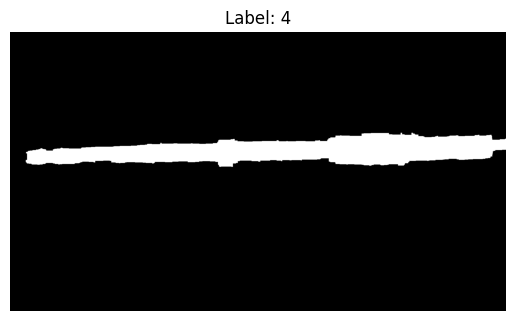

In [220]:
label = sorted_labels[0]
main_comp = extract_component(closing, labels_im, label)
plt.axis('off')
plt.title("Label: {}".format(label))
plt.imshow(main_comp, cmap='gray')
plt.show()

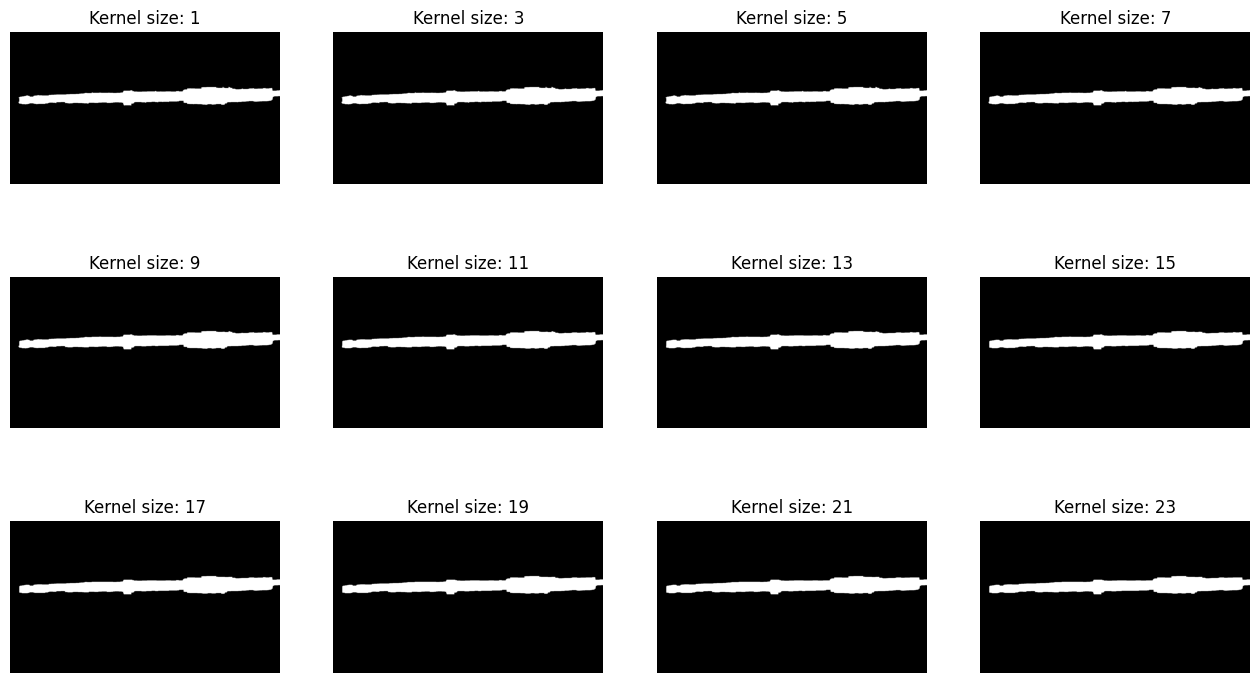

In [221]:
plt.figure(figsize=(16, 9))
for i, j in enumerate(range(1, 25, 2)):
    plt.subplot(3, 4, i + 1)
    kernel = np.ones((j, j), np.int8)
    opening = cv2.morphologyEx(main_comp, cv2.MORPH_OPEN, kernel)
    plt.axis('off')
    plt.title("Kernel size: {}".format(j))
    plt.imshow(opening, cmap='gray')
plt.show()

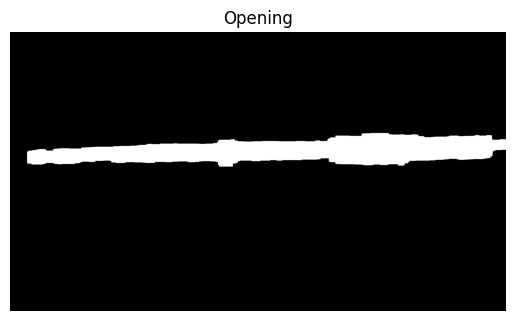

In [222]:
kernel = np.ones((15, 15), np.int8)
main_comp = cv2.morphologyEx(main_comp, cv2.MORPH_OPEN, kernel)
plt.axis('off')
plt.title("Opening")
plt.imshow(main_comp, cmap='gray')
plt.show()

In [ ]:
# def smooth_raster_lines(im, filterRadius, filterSize, sigma):
#     smoothed = np.zeros_like(im)
#     contours, hierarchy = cv2.findContours(im, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
#     hierarchy = hierarchy[0]
#     for countur_idx, contour in enumerate(contours):
#         len_ = len(contour) + 2 * filterRadius
#         idx = len(contour) - filterRadius

#         x = []
#         y = []    
#         for i in range(len_):
#             x.append(contour[(idx + i) % len(contour)][0][0])
#             y.append(contour[(idx + i) % len(contour)][0][1])

#         x = np.asarray(x, dtype=np.float32)
#         y = np.asarray(y, dtype=np.float32)

#         xFilt = cv2.GaussianBlur(x, (filterSize, filterSize), sigma, sigma)
#         xFilt = [q[0] for q in xFilt]
#         yFilt = cv2.GaussianBlur(y, (filterSize, filterSize), sigma, sigma)
#         yFilt = [q[0] for q in yFilt]


#         smoothContours = []
#         smooth = []
#         for i in range(filterRadius, len(contour) + filterRadius):
#             smooth.append([xFilt[i], yFilt[i]])

#         smoothContours = np.asarray([smooth], dtype=np.int32)


#         color = (0,0,0) if hierarchy[countur_idx][3] > 0 else (255,255,255)
#         cv2.drawContours(smoothed, smoothContours, 0, color, -1)
    
#     return(smoothed)

In [ ]:
# # contour smoothing parameters for gaussian filter
# filterRadius = 20; # you can try to change this value
# filterSize = 2 * filterRadius + 1;
# sigma = 10; # you can try to change this value

# smoothed_image = smooth_raster_lines(closing, filterRadius, filterSize, sigma)
# plt.figure(figsize=(16, 12))
# plt.axis('off')
# plt.title('Smoothed edge')
# plt.imshow(smoothed_image, cmap='gray')
# plt.show()

In [236]:
def get_area(image):
    return np.sum(image == 255)

print('Area: ', get_area(main_comp))

Area:  147921


In [238]:
def bf(image, x, y):
    return 1 if image[y, x] > 0 else 0

def get_center(image, area):
    
    x_sum = 0
    y_sum = 0
    h, w = image.shape
    for x in range(w):
        for y in range(h):
            x_sum += x * bf(image, x, y)
            y_sum += y * bf(image, x, y)
            
    return (int(x_sum / area), int(y_sum / area))

area = get_area(main_comp)
center = get_center(main_comp, area)
print('Centroid: ({}, {})'.format(*center))


Centroid: (1078, 459)


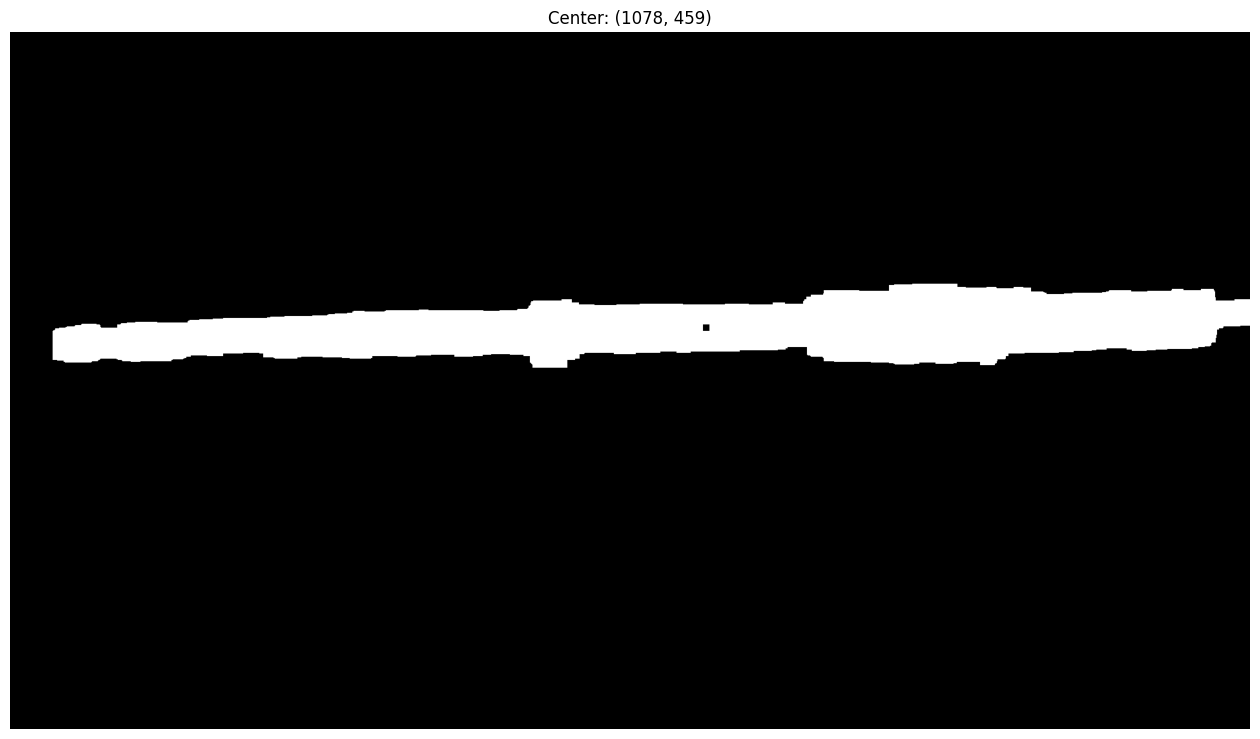

In [239]:
def draw_center(image, center):
    image_copy = image.copy()
    # image_copy = cv2.circle(image_copy, (int(center[0]), int(center[1])), radius=10, color=(0, 255, 0), thickness=-1)
    
    image_copy[center[1] - 5:center[1] + 5, center[0] - 5:center[0] + 5] = np.zeros((10, 10))
    
    plt.figure(figsize=(16, 12))
    plt.axis('off')
    plt.imshow(image_copy, cmap='gray')
    plt.title('Center: {}'.format(center))
    plt.show()
    
draw_center(main_comp, center)

In [240]:
def get_abc(image, area, center):
    a = 0
    b = 0
    c = 0
    
    x_, y_ = center
    
    h, w = image.shape
    for x in range(w):
        for y in range(h):
            _x = x - x_
            _y = y - y_
            a += _x ** 2 * bf(image, x, y)
            b += 2 * _x * _y  * bf(image, x, y)
            c += _y ** 2 * bf(image, x, y)
            
    return a, b, c

a, b, c = get_abc(main_comp, area, center)
print(a, b, c)

38036566561 -1550134370 112346264


In [241]:
def get_theta(image, degree=True):
    area = get_area(image)
    center = get_center(image, area)
    a, b, c = get_abc(image, area, center)
    
    return math.atan(b / (a - c)) * (180 / np.pi if degree else 1) / 2

In [242]:
theta = get_theta(main_comp)
print('Theta: {:.4f}'.format(theta))

Theta: -1.1703


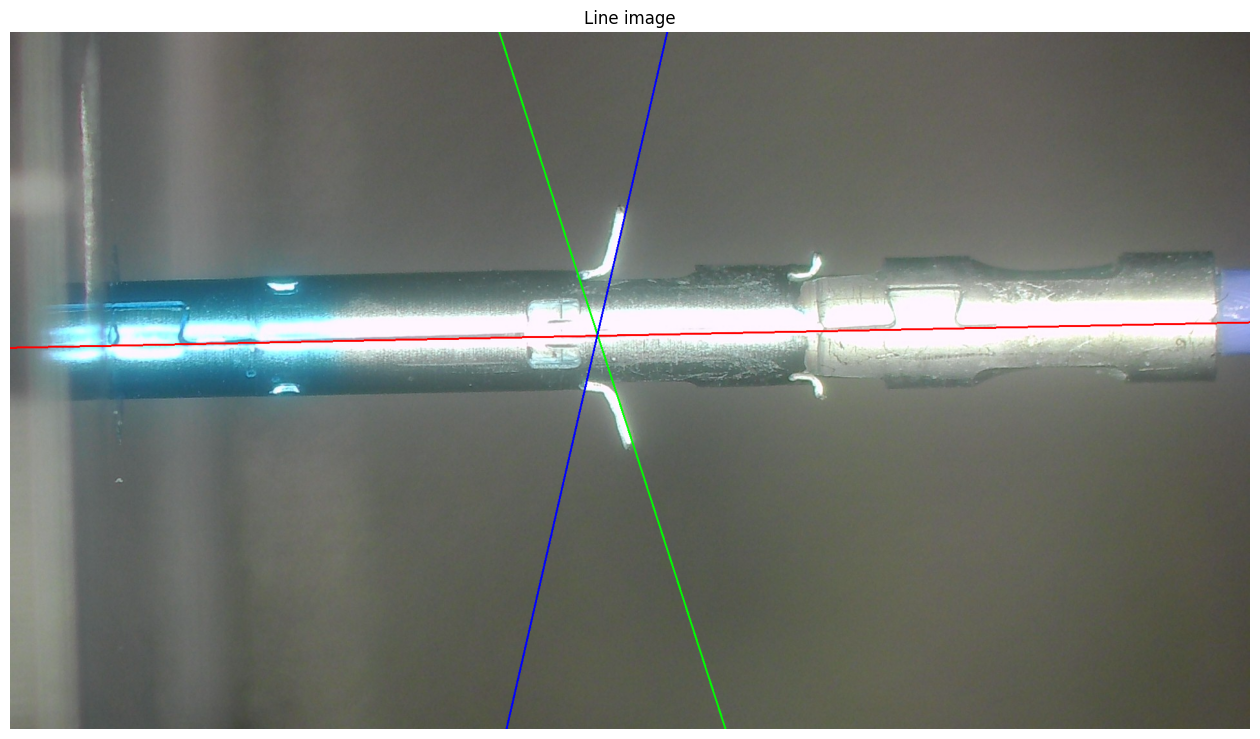

In [249]:
image = cv2.imread(image_path)
line_image = draw_line(image, 490, theta * np.pi / 180 + np.pi / 2, (255, 0, 0))
line_image = draw_line(line_image, -720, 162 * np.pi / 180, (0, 255, 0))
line_image = draw_line(line_image, 991, 13 * np.pi / 180, (0, 0, 255))
plt.figure(figsize=(16, 12))
plt.axis('off')
plt.imshow(line_image, cmap='gray')
plt.title("Line image")
plt.show()
